# import및 데이터 불러오기

In [ ]:
import pandas as pd
import yfinance as yf
start = '2011-01-01'
end = '2022-08-01'
symbol = "AAPL"
df = yf.download(symbol,start , end)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df.to_csv('AAPL_data.csv')

In [ ]:
# pmdarima install

#pip install pmdarima

In [3]:
import os

import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

<ipython-input-3-af653bc158c1>:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [5]:
# yfinance로 APPLE주가 가져오기
import yfinance as yf
df = yf.download('AAPL',
                     start='2021-01-01',
                     end='2023-12-31') #APPLE주가

df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.002106,143301900
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.572327,97664900
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.244392,155088000
2021-01-07,128.360001,131.630005,127.860001,130.919998,128.483994,109578200
2021-01-08,132.429993,132.630005,130.229996,132.050003,129.592987,105158200


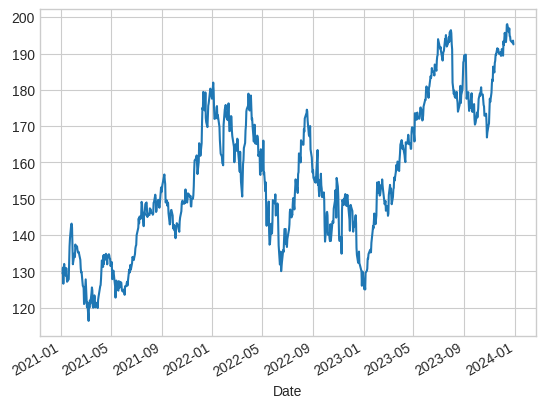

In [6]:
#종가 시각화
fig = df['Close'].plot()

# Decomposition

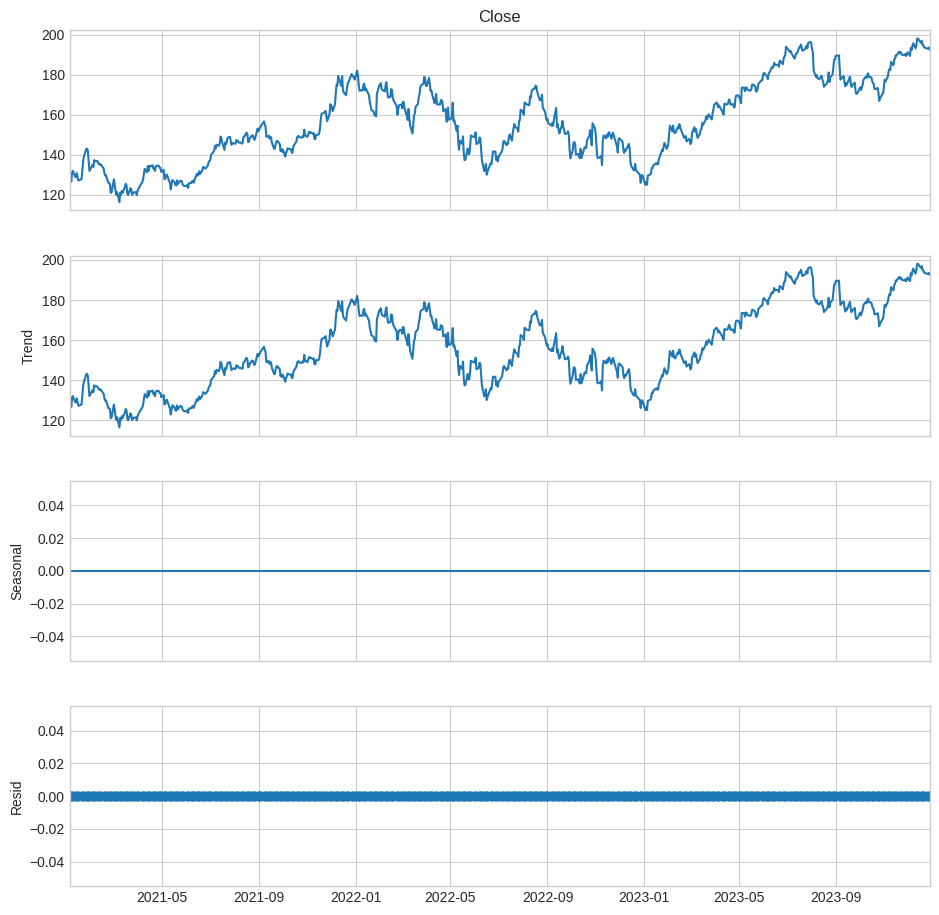

In [7]:
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=1) #model='additive'으로 덧셈분해
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

# 자기상관함수(ACF), 부분자기상관함수(PACF)

In [8]:
# split 8 : 2
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

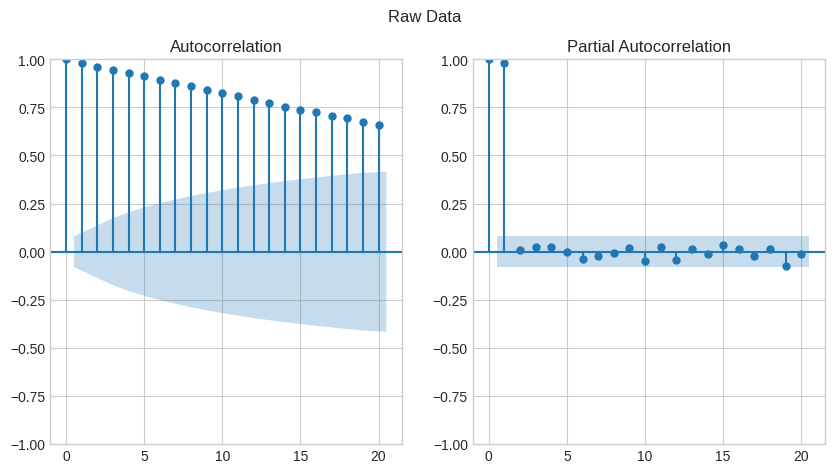

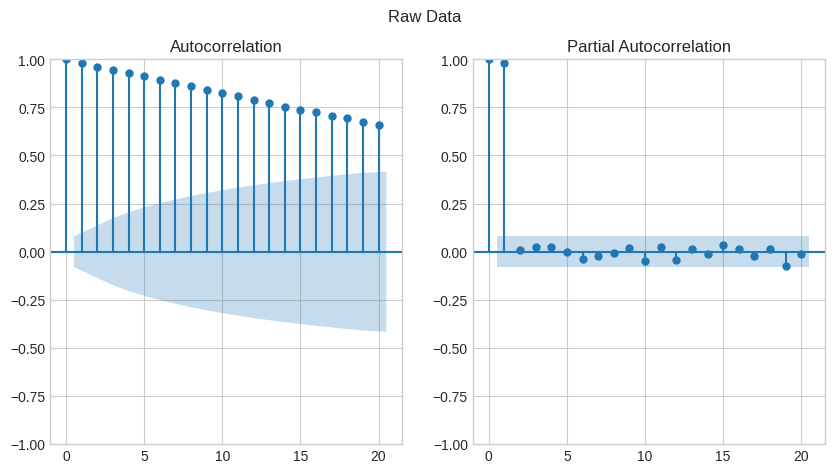

In [9]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['Close'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['Close'].values.squeeze(), lags=20, ax=ax[1])

In [11]:
# Non-stationary -> stationary 보정 (차분, difference)
# differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거
print('*' * 15 + 'Raw data' + '*' * 15)
print(train_data['Close'].head())
print('*' * 15 + 'Differenced data' + '*' * 15)
print(diff_train_data.head())

***************Raw data***************
Date
2021-01-04    129.410004
2021-01-05    131.009995
2021-01-06    126.599998
2021-01-07    130.919998
2021-01-08    132.050003
Name: Close, dtype: float64
***************Differenced data***************
Date
2021-01-05    1.599991
2021-01-06   -4.409996
2021-01-07    4.320000
2021-01-08    1.130005
2021-01-11   -3.070007
Name: Close, dtype: float64


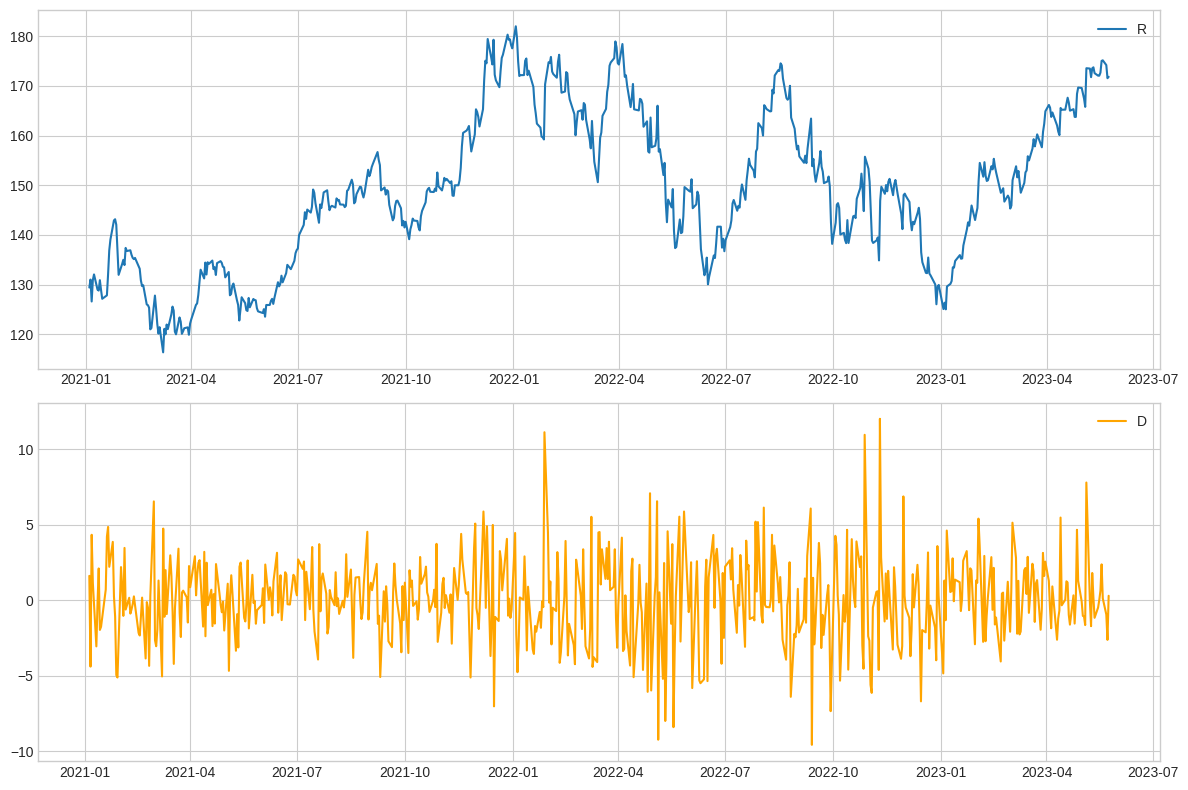

In [12]:
# 차분 시각화

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(train_data['Close'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_train_data, color='orange' )
ax2.legend('Differenced data (stationary)')


plt.tight_layout()
plt.show()

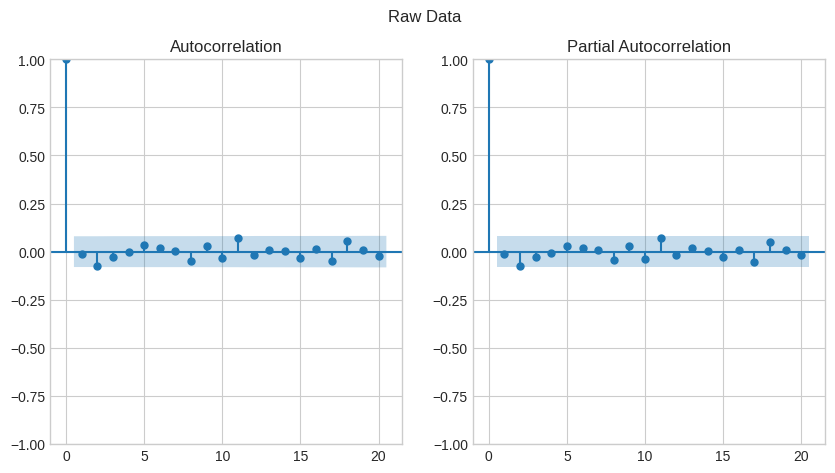

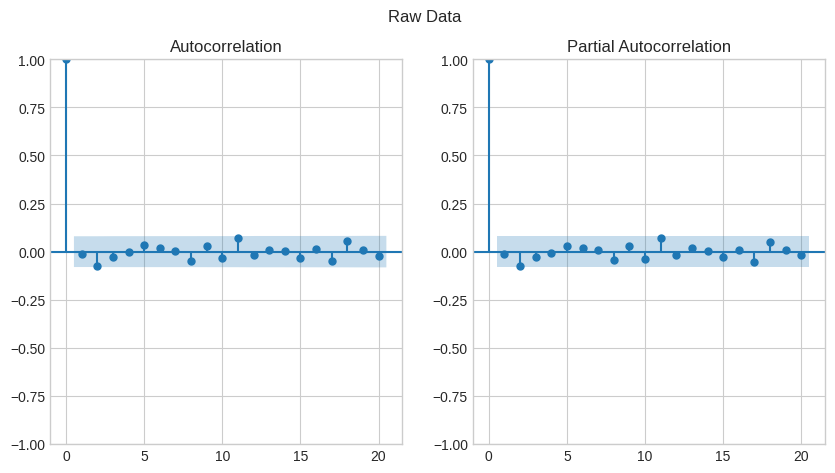

In [13]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=20, ax=ax[1])

# Diagnosis

In [15]:
# 최적 파라미터 서치
import itertools

p = range(0, 2)
d = range(1, 3)
q = range(0, 2)
pdq = list(itertools.product(p, d, q))

AIC = []
for param in pdq:
    try:
        model = SARIMAX(train_data['Close'].values, order=param)
        model_fit = model.fit()
        print(f'SARIMA {param} >> AIC : {round(model_fit.aic, 2)}')
        AIC.append((param, model_fit.aic))
    except:
        continue


SARIMA (0, 1, 0) >> AIC : 2936.57
SARIMA (0, 1, 1) >> AIC : 2938.44
SARIMA (0, 2, 0) >> AIC : 3356.49
SARIMA (0, 2, 1) >> AIC : 2940.7
SARIMA (1, 1, 0) >> AIC : 2938.46
SARIMA (1, 1, 1) >> AIC : 2939.1
SARIMA (1, 2, 0) >> AIC : 3207.75
SARIMA (1, 2, 1) >> AIC : 2942.6


In [16]:
# optimal paramter
optim = [(pdq[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print('Found Optimal Parameter :',optim)

Found Optimal Parameter : [((0, 1, 0), ((0, 1, 0), 2936.569766631666))]


In [19]:
# SARIMAX 모델 사용
model = SARIMAX(train_data['Close'], order=(0, 1, 0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  602
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1467.285
Date:                Mon, 04 Mar 2024   AIC                           2936.570
Time:                        05:32:53   BIC                           2940.968
Sample:                             0   HQIC                          2938.282
                                - 602                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.7286      0.347     22.264      0.000       7.048       8.409
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                42.51
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Forecasting with ARIMA

In [74]:
import pmdarima as pm
from pmdarima.arima import ndiffs
data = df['Close']
n_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [75]:
model = pm.auto_arima(
            y=data,
            d=1,
            start_p=0, max_p=3,
            start_q=0, max_q=3,
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3608.455, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3610.453, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3610.453, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3607.205, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3611.927, Time=1.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.069 seconds


In [76]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  753
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1802.602
Date:                Mon, 04 Mar 2024   AIC                           3607.205
Time:                        07:42:25   BIC                           3611.827
Sample:                             0   HQIC                          3608.986
                                - 753                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.0729      0.276     25.641      0.000       6.532       7.614
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                70.69
Prob(Q):                              0.96   Pr

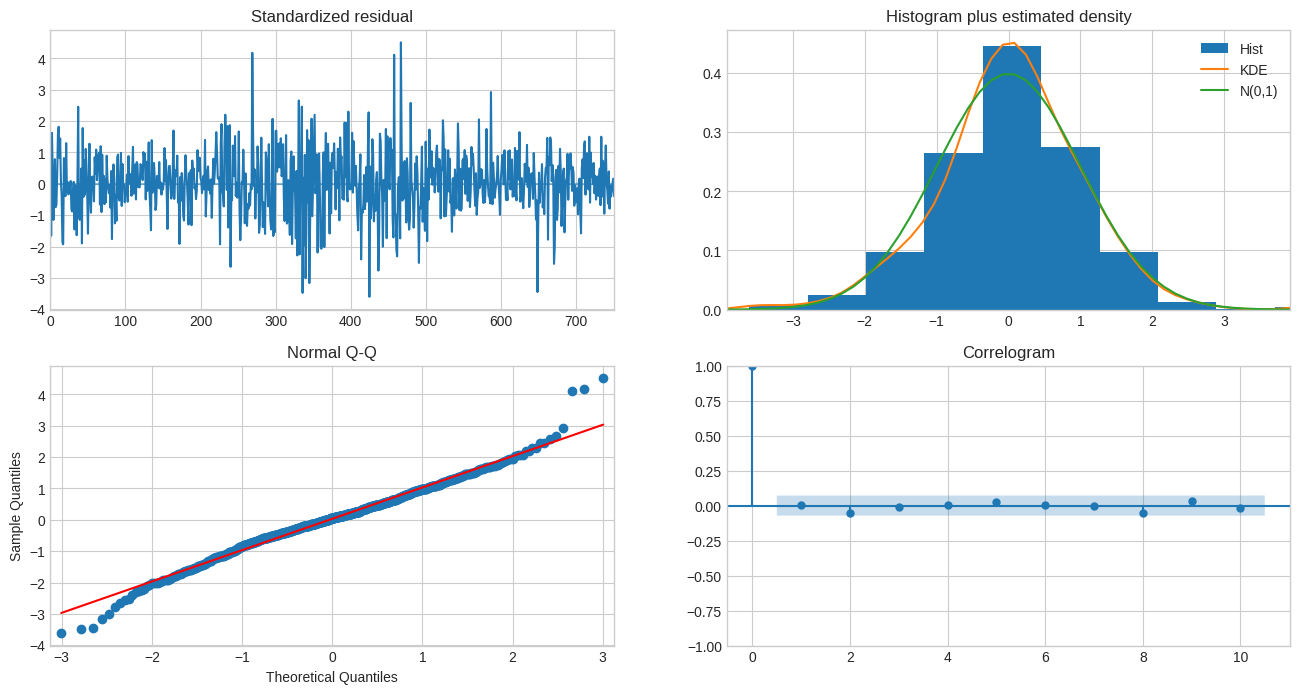

In [77]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [78]:
# train : test = 9 : 1
train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]

In [79]:
from statsmodels.tsa.arima_model import ARIMA

model_fit = pm.auto_arima(
    	    y=train_data,
 	        d=n_diffs ,
            start_p=0, max_p=2,
            start_q=0, max_q=2,
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3283.071, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3285.070, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3285.070, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3281.505, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3286.297, Time=0.84 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.327 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  677
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1639.753
Date:                Mon, 04 Mar 2024   AIC                           3281.505
Time:                        07:42:34   BIC                           3286.022
Sample:                             0   HQIC                          3283.254
                                - 677                                       

In [80]:
# forecast 함수
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    # print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

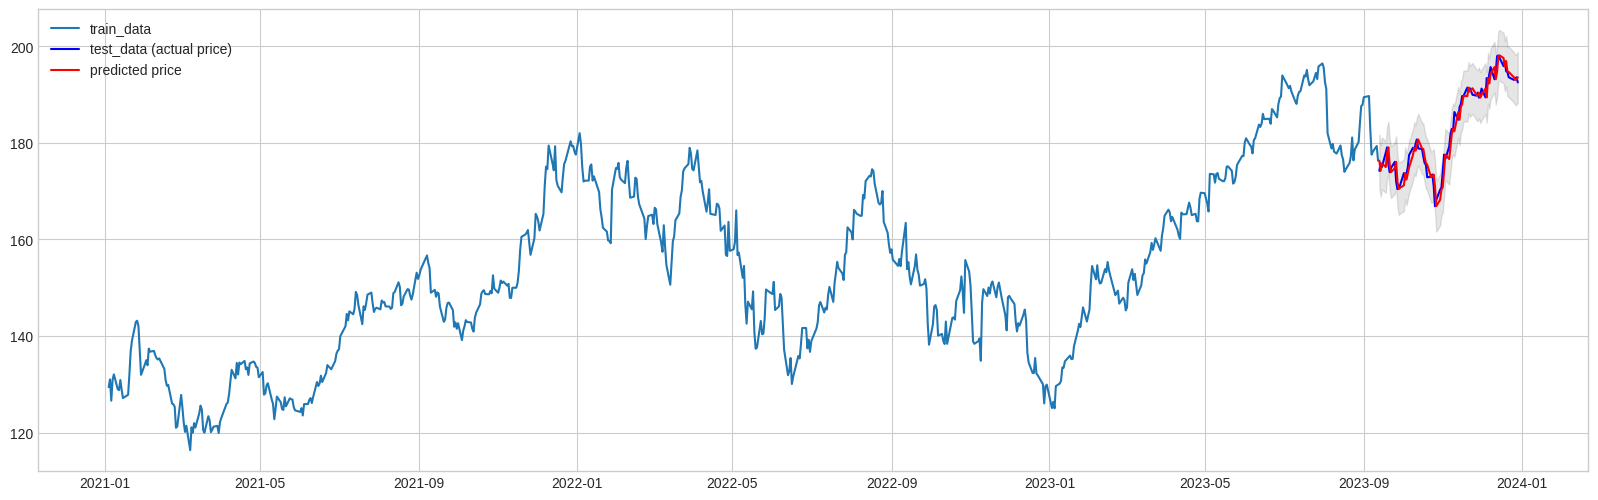

In [81]:
import numpy as np

# Forecast
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data=test_data)

# pandas series 생성
# fc # 예측결과
lower_series = pd.Series(lower, index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(20, 6))
plt.plot(train_data, label='train_data')
plt.plot(test_data, c='b', label='test_data (actual price)')
plt.plot(fc, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()


In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: ' ,'{:.2f}%'.format(mape*100))

MSE:  1.9307941661746832e+170
MAE:  3.7250184279298237e+84
RMSE:  1.3895301962083023e+85
MAPE:  383.29%
